In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
%matplotlib inline
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import sqrt, cos, sin, pi
from numpy.fft import fft, ifft, rfft, irfft
from tqdm import tqdm
import time
import h5py

print(tf.__version__)

2.3.0


### Generate data

In [3]:
filename = '/home/u00u55a9vfjZYf2s1k357/plasma_closure/data/data-2d-T2qxxx.h5'

In [4]:
ls -lh '/home/u00u55a9vfjZYf2s1k357/plasma_closure/data/data-2d-T2qxxx.h5'

-rwxrwxrwx 1 u00u55a9vfjZYf2s1k357 u00u55a9vfjZYf2s1k357 9.8G Aug 25 19:46 /home/u00u55a9vfjZYf2s1k357/plasma_closure/data/data-2d-T2qxxx.h5*


In [5]:
def read_T_q(filename, nsamples=None):
    with h5py.File(filename, 'r') as file:
        print('full data shape', file['Txx1'].shape)
        T = file['Txx1'][slice(nsamples), ...]
        q = file['qxxx'][slice(nsamples), ...]
        return T, q
    
def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [6]:
T, q = read_T_q(filename)
T.shape, q.shape

full data shape (10000, 256, 256)


((10000, 256, 256), (10000, 256, 256))

In [7]:
nsamples, nx, ny = T.shape  # FIXME nx, ny order?

In [8]:
T = T.reshape((nsamples, nx, ny, 1))
q = q.reshape((nsamples, nx, ny, 1))

In [9]:
T = normalize(T)
q = normalize(q)

In [10]:
test_split = 0.05
nsamples_test = int(nsamples * test_split)
nsamples_train = nsamples - nsamples_test

In [11]:
train_data = T[:nsamples_train, ...]
train_labels = q[:nsamples_train, ...]

test_data = T[nsamples_train:, ...]
test_labels = q[nsamples_train:, ...]

### Create the model

In [12]:
num_filters = 48

# input = keras.Input(shape=train_data.shape[1:])
# layer1 = layers.Conv2D(num_filters, 16, activation='relu', padding='same',
#                        input_shape=train_data.shape[1:])(input),
# layer2 = layers.Dropout(0.5)(layer1)
# layer3 = layers.MaxPool2D(padding='same')(layer2)
# layer4 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(layer3),
# layer5 = layers.Dropout(0.5)(layer4)
# layer6 = layers.MaxPool2D(padding='same')(layer5)
# layer7 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(layer6),
# model = layers.Conv2D(1, 1, padding='same', activation='linear')(layer7)

# https://www.machinecurve.com/index.php/2019/12/11/upsampling2d-how-to-use-upsampling-with-keras/#building-your-model-with-keras
model = keras.Sequential([
    layers.Conv2D(num_filters, 16, activation='relu', padding='same', input_shape=train_data.shape[1:]),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(1, 1, padding='same', activation='linear')
])



model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=1e-5),
              metrics=['accuracy', 'mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 48)      12336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 48)      589872    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 48)        589872    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 48)        589872    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 48)      0

### Train the model

In [15]:
EPOCHS = 5  # How many times we go through the entire dataset
validation_split = 0.05  # fraction of data to be used as live validation


# https://keras.io/guides/writing_your_own_callbacks/
class PrintLogs(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.time_begin = time.time()

    def on_epoch_end(self, epoch, logs):
        if epoch >0 and (epoch+1) % 1 == 0:
            info = ''
            info += 'EPOCH {}'.format(epoch)
            dt = time.time() - self.time_begin
            dt_per_epoch = dt / (epoch + 1)
            info +='; time total {:g}s per-epoch {:g}s:'.format(dt, dt_per_epoch)
            log_epoch = [
                '{} {:.1e}'.format(key, logs[key]) for key in logs.keys()
            ]
            info += '; '.join(log_epoch)
            print(info)


callbacks = [
#     PrintLogs(),
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.TensorBoard(log_dir="./logs-qxxx")
]

# https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(train_data,
                    train_labels,
                    epochs=EPOCHS,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=callbacks,
                   )

Epoch 1/5
283/283 [==============================] - 28s 98ms/step - loss: 1.1949e-04 - accuracy: 1.6907e-09 - mae: 0.0079 - mse: 1.1949e-04 - val_loss: 1.2911e-04 - val_accuracy: 0.0000e+00 - val_mae: 0.0081 - val_mse: 1.2911e-04
Epoch 2/5
283/283 [==============================] - 28s 97ms/step - loss: 1.1907e-04 - accuracy: 1.6907e-09 - mae: 0.0078 - mse: 1.1907e-04 - val_loss: 1.3792e-04 - val_accuracy: 0.0000e+00 - val_mae: 0.0085 - val_mse: 1.3792e-04
Epoch 3/5
283/283 [==============================] - 28s 97ms/step - loss: 1.1955e-04 - accuracy: 1.6907e-09 - mae: 0.0079 - mse: 1.1955e-04 - val_loss: 1.2193e-04 - val_accuracy: 0.0000e+00 - val_mae: 0.0079 - val_mse: 1.2193e-04
Epoch 4/5
283/283 [==============================] - 28s 97ms/step - loss: 1.1748e-04 - accuracy: 1.6907e-09 - mae: 0.0078 - mse: 1.1748e-04 - val_loss: 1.5011e-04 - val_accuracy: 0.0000e+00 - val_mae: 0.0088 - val_mse: 1.5011e-04
Epoch 5/5
283/283 [==============================] - 28s 97ms/step - loss: 1

### Benchmark the model

In [14]:
# Use the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

NameError: name 'history' is not defined

In [ ]:
def plot_history(history, step=1):
    fig = plt.figure(figsize=(12, 3))
    hist = pd.DataFrame(history.history).iloc[::step]
    hist['epoch'] = history.epoch[::step]

    plt.subplot(131)
    plt.semilogy(hist['epoch'], hist['mae'], label='training')
    plt.semilogy(hist['epoch'], hist['val_mae'], label='test', alpha=0.8)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (mae)')

    plt.subplot(132)
    plt.semilogy(hist['epoch'], hist['mse'], label='training')
    plt.semilogy(hist['epoch'], hist['val_mse'], label='test', alpha=0.8)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error (mse)')

    plt.tight_layout()


plot_history(history)

In [ ]:
# Compute the overall scores of the model
scores = model.evaluate(test_data, test_labels, verbose=1)

In [19]:
test_predictions = model.predict(test_data)

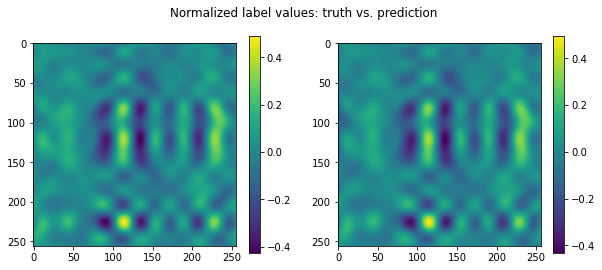

In [20]:
# compare truth and prediction for one or more test samples
for itest in range(1):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(test_labels[itest, ..., 0])
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(test_predictions[itest, ..., 0])
    plt.colorbar()
    plt.suptitle('Normalized label values: truth vs. prediction')

(-1.1, 1.1, -1.1, 1.1)

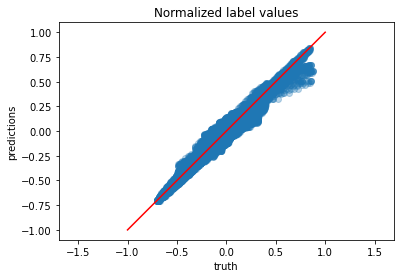

In [21]:
# do the 45-degree plot; close to the diagonal == good
plt.plot((-1, 1), (-1, 1), c='r')
plt.scatter(test_labels.ravel(), test_predictions.ravel(), alpha=0.3)
plt.xlabel('truth')
plt.ylabel('predictions')
plt.title('Normalized label values')
plt.axis('equal')

### Save the model

In [17]:
model_filename = 'closure-2d-model-qxxx.h5'
model.save(model_filename)

In [18]:
import h5py

model_file = h5py.File(model_filename, 'r')


def print_obj(name, obj):
    info = ''
    if isinstance(obj, h5py._hl.dataset.Dataset):
        info = str(obj.shape)
    print('{:42s} {:10s} {}'.format(name, info, type(obj)))


model_file.visititems(print_obj)

model_file.close()

model_weights                                         <class 'h5py._hl.group.Group'>
model_weights/dense                                   <class 'h5py._hl.group.Group'>
model_weights/dense/dense                             <class 'h5py._hl.group.Group'>
model_weights/dense/dense/bias:0           (256,)     <class 'h5py._hl.dataset.Dataset'>
model_weights/dense/dense/kernel:0         (128, 256) <class 'h5py._hl.dataset.Dataset'>
model_weights/dense_1                                 <class 'h5py._hl.group.Group'>
model_weights/dense_1/dense_1                         <class 'h5py._hl.group.Group'>
model_weights/dense_1/dense_1/bias:0       (256,)     <class 'h5py._hl.dataset.Dataset'>
model_weights/dense_1/dense_1/kernel:0     (256, 256) <class 'h5py._hl.dataset.Dataset'>
model_weights/dense_2                                 <class 'h5py._hl.group.Group'>
model_weights/dense_2/dense_2                         <class 'h5py._hl.group.Group'>
model_weights/dense_2/dense_2/bias:0       (128,)